# Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Homework 1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2023-2024] AN2DL/Homework 1


# Importing data

In [ ]:
seed = 31

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)


import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)


import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import NeighbourhoodCleaningRule

2.14.0


In [ ]:
%pip install keras-tuner
import keras_tuner as kt

In [ ]:
unzip = False

if unzip:
    !unzip public_data.zip

In [ ]:
data = np.load('public_data.npz', allow_pickle = True)

In [ ]:
X = []


for image in data["data"]:

    image = (image / 255).astype(np.float32)
    #image = image[..., ::-1]

    #dim = min(image.shape[:-1])
    #image = image[(image.shape[0] - dim) // 2:(image.shape[0] + dim) // 2, (image.shape[1] - dim) // 2:(image.shape[1] + dim) // 2, :]

    #image = tfkl.Resizing(299, 299)(image)

    if image is not None:
        X.append(image)

X = np.array(X)

Y = data["labels"]
Y[Y == "healthy"] = 0
Y[Y == "unhealthy"] = 1


In [ ]:
X.shape, Y.shape

# Data cleaning

In [ ]:
X, indexes, counts = np.unique(X, axis=0, return_index=True, return_counts=True) #removes duplicates from the datatset
Y = Y[indexes]
X.shape, Y.shape

In [ ]:
duplicates = [] #checks which elements had more than 1 copy
for i, num in enumerate(counts):
    if num > 1:
        duplicates.append(i)

In [ ]:
len(duplicates)

In [ ]:
#visualize duplicates

visualize = False
if visualize:
    fig, axs = plt.subplots(nrows = 14, ncols = 10, figsize = (20,20))
    axs = axs.reshape(-1)

    for i, num in enumerate(duplicates):
        axs[i].imshow(X[num])
        axs[i].set_title(num)

In [ ]:
#delete anomalies
X = np.delete(X, [802, 4787], axis=0)
Y = np.delete(Y, [802, 4787], axis=0)

In [ ]:
X.shape, Y.shape

# Train test split

In [ ]:
# Convert labels to one-hot encoding format
Y = tfk.utils.to_categorical(Y, 2)

In [ ]:
Y.shape

In [ ]:
print(f"Original Data Shape: {X.shape}")
print(f"Original Label Shape: {Y.shape}\n")

# First Split: Training/Validation and Test sets
x_train_val, x_test, y_train_val, y_test = train_test_split(X, Y, random_state = seed, test_size = .1, stratify = np.argmax(Y, axis = 1))

#height, width, _ = image.shape
#for img in x_train_val:
#   img[:,:,0] = np.zeros([height, width])

x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=seed, test_size= .15, stratify=np.argmax(y_train_val,axis=1))

Original Data Shape: (4850, 96, 96, 3)
Original Label Shape: (4850, 2)



# Solving class imbalance




In [ ]:
y_train = np.argmax(y_train, axis=-1)

In [ ]:
x_train.shape, y_train.shape

((3710, 96, 96, 3), (3710,))

In [ ]:
np.unique(y_train, axis=0, return_counts=True)

In [ ]:

oversample = RandomOverSampler(sampling_strategy = 0.75)

x_train = x_train.reshape(x_train.shape[0], 96*96*3)
y_train = y_train.astype('int')
x_train, y_train = oversample.fit_resample(x_train, y_train)


#undersample = NeighbourhoodCleaningRule(n_neighbors=3)

#x_train, y_train = undersample.fit_resample(x_train, y_train)
x_train = x_train.reshape(x_train.shape[0], 96, 96, 3)

In [ ]:
x_train.shape, y_train.shape

In [ ]:
visualize = False

state = {0: "healthy", 1: "unhealthy"}

if visualize:
    fig, axs = plt.subplots(nrows = 10, ncols = 10, figsize = (20,20))
    axs = axs.reshape(-1)

    for i in range(100):
        axs[i].imshow(x_train[-i])
        axs[i].set_title(state[y_train[-i]])

In [ ]:
y_train = tfk.utils.to_categorical(y_train, 2)

# Xception


In [ ]:
import tensorflow.keras.applications.xception

83683744/83683744 [==============================] - 3s 0us/step


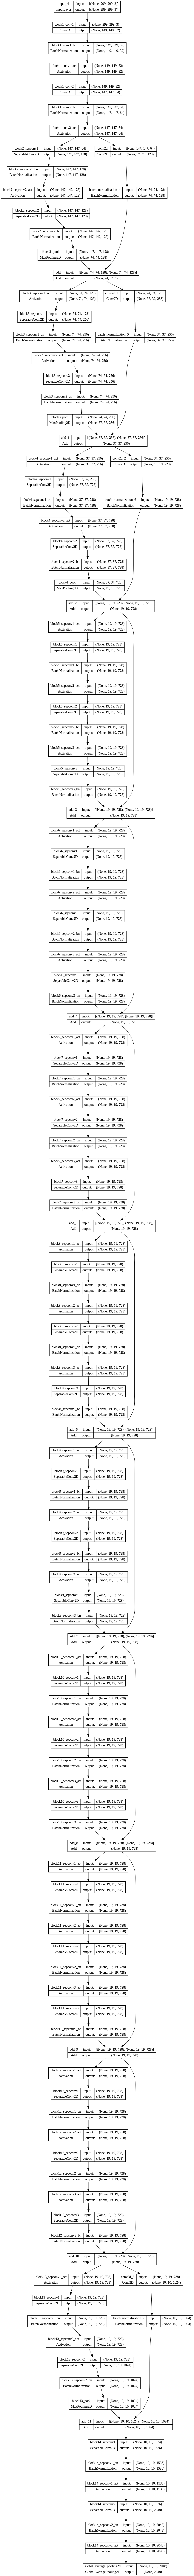

In [ ]:
xception = tfk.applications.Xception(
    input_shape=(299, 299, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

# Display the model architecture with input shapes
tfk.utils.plot_model(xception, show_shapes=True)

In [ ]:
def model_builder(model_name, resize_shape):
    #sets weights to false:
    xception.trainable = False

    preprocessing = tf.keras.Sequential([
            tfkl.RandomTranslation(0.2, 0.2),
            tfkl.RandomFlip("horizontal"),
            tfkl.RandomFlip("vertical"),
            tfkl.RandomZoom(0.1),
            tfkl.RandomRotation(1),
            tf.keras.layers.Resizing (resize_shape, resize_shape)
        ], name='preprocessing')

    inputs = tfk.Input(shape=(96, 96, 3))

    preprocessing = preprocessing(inputs)

    # Connect Xception to the input
    x = model_name(preprocessing)


    batch = tf.keras.layers.BatchNormalization()(x)
    dense = tfkl.Dense(128, activation = "relu")(batch)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    batch = tf.keras.layers.BatchNormalization()(dense)
    outputs = tfkl.Dense(2, "softmax")(batch)

    # Create a Model connecting input and output
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

    # Display model summary
    model.summary()

    return model



In [ ]:
lr_patience = 7
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.9,          # Factor by which the learning rate will be reduced (0.9 in this case)
    mode='max',            # Mode to decide when to reduce learning rate

In [ ]:
model = model_builder(xception, 299)

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

In [ ]:
history = model.fit(
    x = xception.preprocess_input(x_train*255), # We need to apply the preprocessing thought for the xception network
    y = y_train,
    batch_size = 128,
    epochs = 200,
    validation_data = (preprocess_input(x_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=12, restore_best_weights=True), lr_scheduler],
).history

In [ ]:
#del model, history

In [ ]:
model.save('XceptionAugmentedTransferLearningModel3')
del model

# EfficientNetV2


In [ ]:
import tensorflow.keras.applications.efficientnet_v2

In [ ]:
efficientnet_v2 = tf.keras.applications.EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    include_preprocessing=True,
    input_shape=(96,96,3),
    pooling='max'
)

214201816/214201816 [==============================] - 1s 0us/step


In [ ]:
def model_builder_preprocess_included(model_name,):
    #sets weights to false:
    efficientnet_v2.trainable = False

    preprocessing = tf.keras.Sequential([
            tfkl.RandomTranslation(0.2, 0.2),
            tfkl.RandomFlip("horizontal"),
            tfkl.RandomFlip("vertical"),
            tfkl.RandomZoom(0.1),
            tfkl.RandomRotation(1),
            tfkl.RandomContrast(0.3)
        ], name='preprocessing')

    inputs = tfk.Input(shape=(96, 96, 3))

    preprocessing = preprocessing(inputs)

    # Connect MobileNetV2 to the input
    x = model_name(preprocessing)


    batch = tf.keras.layers.BatchNormalization()(x)
    dense = tfkl.Dense(128, activation = "relu")(batch)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    batch = tf.keras.layers.BatchNormalization()(dense)
    outputs = tfkl.Dense(2, "softmax")(batch)

    # Create a Model connecting input and output
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

    # Display model summary
    model.summary()

    return model


In [ ]:
model2 = model_builder_preprocess_included(efficientnet_v2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 efficientnetv2-m (Function  (None, 1280)              53150388  
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512   

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4096, 96, 96, 3), (4096, 2), (655, 96, 96, 3), (655, 2))

In [ ]:
lr_patience = 10
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.95,          # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='auto',
)

In [ ]:
history2 = model2.fit(
    x = x_train*255, # We need to apply the preprocessing thought for the xception network
    y = y_train,
    batch_size = 128,
    epochs = 200,
    validation_data = (x_val*255, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True), lr_scheduler],
).history

Epoch 1/200
32/32 [==============================] - 37s 277ms/step - loss: 0.7279 - accuracy: 0.6538 - val_loss: 0.5140 - val_accuracy: 0.7389 - lr: 0.0010
Epoch 2/200
32/32 [==============================] - 3s 90ms/step - loss: 0.5613 - accuracy: 0.7170 - val_loss: 0.5009 - val_accuracy: 0.7740 - lr: 0.0010
Epoch 3/200
32/32 [==============================] - 3s 91ms/step - loss: 0.5377 - accuracy: 0.7261 - val_loss: 0.4651 - val_accuracy: 0.7863 - lr: 0.0010
Epoch 4/200
32/32 [==============================] - 3s 91ms/step - loss: 0.5375 - accuracy: 0.7371 - val_loss: 0.4496 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 5/200
32/32 [==============================] - 3s 81ms/step - loss: 0.5065 - accuracy: 0.7485 - val_loss: 0.4881 - val_accuracy: 0.7588 - lr: 0.0010
Epoch 6/200
32/32 [==============================] - 3s 81ms/step - loss: 0.5254 - accuracy: 0.7366 - val_loss: 0.4520 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 7/200
32/32 [==============================] - 3s 90ms/step - 

In [ ]:
model2.save('temp')
del model2

# Model comparison


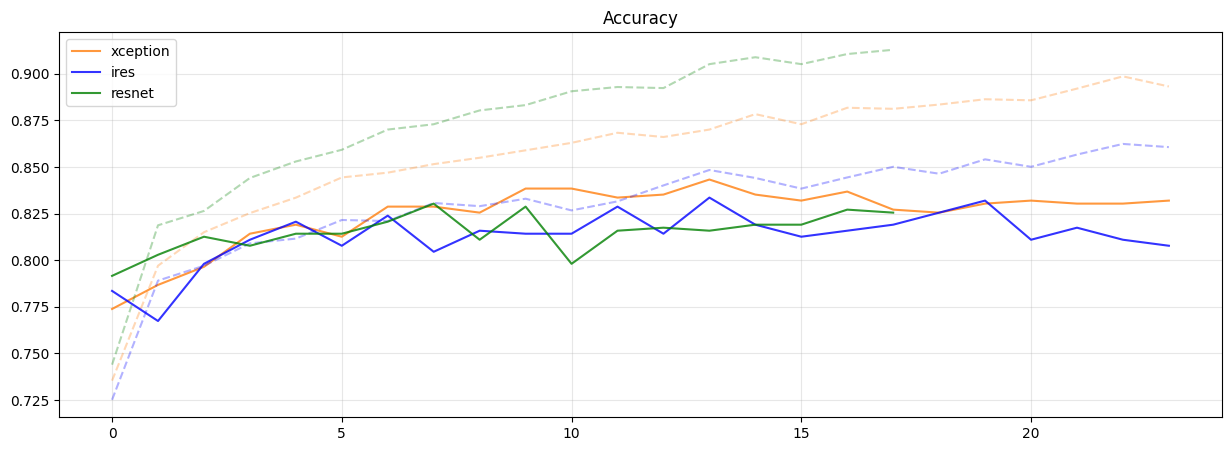

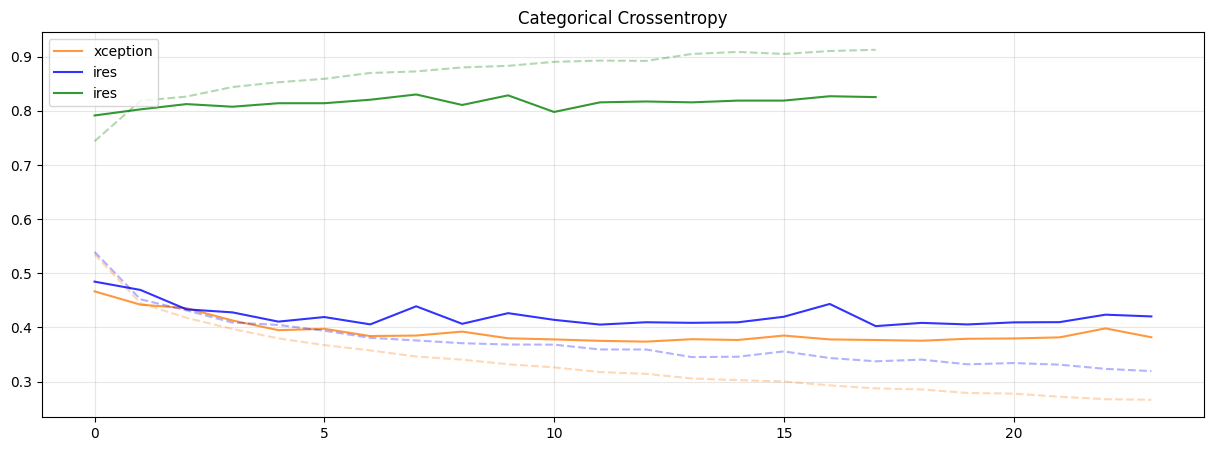

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='xception', alpha=.8, color='#ff7f0e')
plt.plot(ires_history['accuracy'], alpha=.3, linestyle='--', color = 'b')
plt.plot(ires_history['val_accuracy'], label='ires', alpha=.8, color = 'b')
plt.plot(resnet_history['accuracy'], alpha=.3, linestyle='--', color = 'g')
plt.plot(resnet_history['val_accuracy'], label='resnet', alpha=.8, color = 'g')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='xception', alpha=.8, color='#ff7f0e')
plt.plot(ires_history['loss'], alpha=.3, linestyle='--', color = 'b')
plt.plot(ires_history['val_loss'], label='ires', alpha=.8, color = 'b')
plt.plot(resnet_history['accuracy'], alpha=.3, linestyle='--', color = 'g')
plt.plot(resnet_history['val_accuracy'], label='ires', alpha=.8, color = 'g')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.show()

# Fine tuning

In [ ]:
ft_model = tfk.models.load_model('temp')

In [ ]:
ft_model.get_layer('efficientnetv2-m').trainable = True
# Freeze first N layers, e.g., until the 133rd one
N = 230
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-m').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-m').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 rescaling False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block1c_project_conv False
15 block1c_project_bn False
16 block1c_project_activation False
17 block1c_drop False
18 block1c_add False
19 block2a_expand_conv False
20 block2a_expand_bn False
21 block2a_expand_activation False
22 block2a_project_conv False
23 block2a_project_bn False
24 block2b_expand_conv False
25 block2b_expand_bn False
26 block2b_expand_activation False
27 block2b_project_conv False
28 block2b_project_bn False
29 block2b_drop False
30 block2b_add False
31 block2c_expand_conv False
32 block2c_expand_bn False
33 block2c_expand_activation False
34 block2c_project_conv False
35 block2c_project_bn False
36 block2c_drop False
37 block2c_a

In [ ]:
# Cosine decay
learning_rate =tfk.optimizers.schedules.CosineDecay(
    initial_learning_rate = 1e-6,
    decay_steps = 10000,
    alpha = 0.0,
    name = None,
    warmup_target = 1e-4,
    warmup_steps = 100
)

lr_patience = 15

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.99,          # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='auto',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
)


optimizer=tfk.optimizers.Adam(learning_rate)
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics = 'accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = x_train*255, # efficient net has a preprocessing layer as part of the model and just needs 255 pixels in
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_val*255, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True), lr_scheduler],
).history

Epoch 1/200
64/64 [==============================] - 75s 221ms/step - loss: 0.7442 - accuracy: 0.6733 - val_loss: 0.5376 - val_accuracy: 0.7710 - lr: 6.3370e-05
Epoch 2/200
64/64 [==============================] - 8s 123ms/step - loss: 0.5807 - accuracy: 0.7302 - val_loss: 0.4393 - val_accuracy: 0.8122 - lr: 9.9998e-05
Epoch 3/200
64/64 [==============================] - 8s 121ms/step - loss: 0.5097 - accuracy: 0.7695 - val_loss: 0.3613 - val_accuracy: 0.8504 - lr: 9.9980e-05
Epoch 4/200
64/64 [==============================] - 8s 124ms/step - loss: 0.4621 - accuracy: 0.7942 - val_loss: 0.3276 - val_accuracy: 0.8672 - lr: 9.9941e-05
Epoch 5/200
64/64 [==============================] - 8s 123ms/step - loss: 0.4256 - accuracy: 0.8069 - val_loss: 0.3106 - val_accuracy: 0.8687 - lr: 9.9882e-05
Epoch 6/200
64/64 [==============================] - 8s 125ms/step - loss: 0.3786 - accuracy: 0.8376 - val_loss: 0.3029 - val_accuracy: 0.8748 - lr: 9.9803e-05
Epoch 7/200
64/64 [====================

In [ ]:
ft_model.save("fineTuned")


In [ ]:
ft_model = tfk.models.load_model('fineTuned')
ft_model.save("upload.keras")

# Finding the best layer to freeze


In [ ]:
# Cosine decay
learning_rate =tfk.optimizers.schedules.CosineDecay(
    initial_learning_rate = 1e-7,
    decay_steps = 10000,
    alpha = 0.0,
    name = None,
    warmup_target = 1e-4,
    warmup_steps = 1000
)

lr_patience = 20

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.95,          # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='auto',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
)


In [ ]:
ft_model = tfk.models.load_model('temp')


In [ ]:
patience = 30
layers = [112, 215, 305, 395, 498, 603, 691]
histories = []
scores = []
best_epochs = []
models = []


In [ ]:
for num in layers:
    model = tf.keras.models.clone_model(ft_model)

    model.get_layer('efficientnetv2-m').trainable = True
    # Freeze first N layers, e.g., until the 133rd one
    N = num
    for i, layer in enumerate(model.get_layer('efficientnetv2-m').layers[:N]):
        layer.trainable=False

    optimizer = tf.keras.optimizers.AdamW(learning_rate)
    models.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics = 'accuracy')



    # Fine-tune the model
    history = models.fit(
        x = x_train*255, # efficient net has a preprocessing layer as part of the model and just needs 255 pixels in
        y = y_train,
        batch_size = 64,
        epochs = 600,
        validation_data = (x_val*255, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
        callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True), lr_scheduler],
    ).history

    models.append(model)

    # Evaluate the model on the validation data for this fold
    score = model.evaluate(x_val*255, y_val, verbose=0)
    scores.append(score[1])

    # Calculate the best epoch for early stopping
    best_epoch = len(history['loss']) - patience
    best_epochs.append(best_epoch)

    # Store the training history for this fold
    histories.append(history)



NameError: ignored

In [ ]:
# Define a list of colors for plotting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Print mean and standard deviation of MSE scores
print("MSE")
print(f"Mean: {np.mean(scores).round(4)}\nStd:  {np.std(scores).round(4)}")

# Create a figure for MSE visualization
plt.figure(figsize=(15,6))

# Plot MSE for each fold
for freeze_idx in range(len(layers)):
  plt.plot(histories[freeze_idx]['val_mse'][:-patience], color=colors[freeze_idx], label=f'Freeze N°{layers[freeze_idx]}')
  plt.ylim(0.009, 0.02)
  plt.title('Mean Squared Error')
  plt.legend(loc='upper right')
  plt.grid(alpha=.3)

# Show the plot
plt.show()


# Test

In [ ]:
ft_model = tfk.models.load_model('upload.keras')

Input image


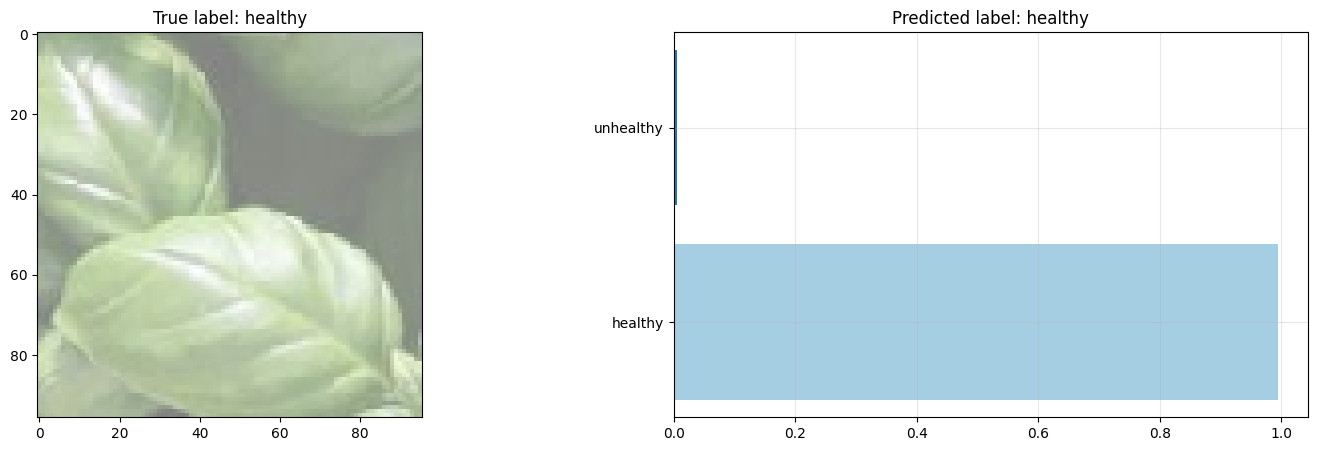

In [ ]:
num_images = 100
labels = {0:"healthy", 1:"unhealthy"}

# Display the input image, true label, and predicted label

for i in range(10)
    # Choose a random image for visualization
    image = np.random.randint(0, num_images)

    # Display the input image, true label, and predicted label
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 5)
    ax1.imshow((x_test[image] + 1) / 2)
    ax1.set_title('True label: ' + labels[np.argmax(y_test[image])])
    prediction = ft_model.predict(np.expand_dims(x_test[image]*255, axis=0), verbose=0)
    ax2.barh(list(labels.values()), np.squeeze(prediction, axis=0), color=plt.get_cmap('Paired').colors)
    ax2.set_title('Predicted label: ' + labels[np.argmax(prediction)])
    ax2.grid(alpha=0.3)



plt.show()

In [ ]:
print(x_test.shape)
predictions = ft_model.predict(x_test*255, verbose = 0)

print("Predictions Shape:", predictions.shape)
print(predictions)

(485, 96, 96, 3)
Predictions Shape: (485, 2)
[[9.54504940e-05 9.99904513e-01]
 [8.51348221e-01 1.48651838e-01]
 [9.99982238e-01 1.77763322e-05]
 [9.98598516e-01 1.40151230e-03]
 [1.10467840e-02 9.88953233e-01]
 [3.19120241e-04 9.99680877e-01]
 [8.41421168e-03 9.91585851e-01]
 [9.99247193e-01 7.52851251e-04]
 [9.96044755e-01 3.95528693e-03]
 [1.63578749e-01 8.36421192e-01]
 [9.99961495e-01 3.85458807e-05]
 [8.92017722e-01 1.07982278e-01]
 [8.55928183e-01 1.44071877e-01]
 [8.67990315e-01 1.32009700e-01]
 [1.60631165e-03 9.98393714e-01]
 [9.99557555e-01 4.42448072e-04]
 [6.97989981e-06 9.99992967e-01]
 [9.53510962e-03 9.90464926e-01]
 [9.65210497e-01 3.47894318e-02]
 [2.18254121e-04 9.99781787e-01]
 [9.99973655e-01 2.63232541e-05]
 [2.94064201e-04 9.99705851e-01]
 [9.99731839e-01 2.68138770e-04]
 [6.53894805e-09 1.00000000e+00]
 [9.87097561e-01 1.29024619e-02]
 [9.92553651e-01 7.44637148e-03]
 [6.19628429e-01 3.80371541e-01]
 [6.20929480e-01 3.79070580e-01]
 [9.99964476e-01 3.54923905e-05

Accuracy: 0.899
Precision: 0.8912
Recall: 0.8921
F1: 0.8917


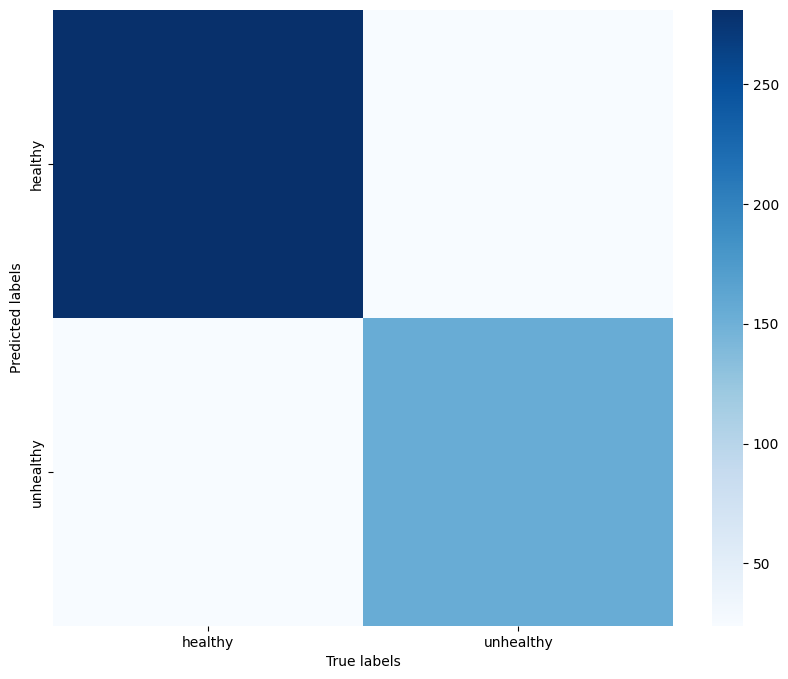

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
ft_model.save("upload2.keras")

# Tuner


In [ ]:
def model_builder_preprocess_included(hp):
    #sets weights to false:

    efficientnet_v2.trainable = True

    preprocessing = tf.keras.Sequential([
            tfkl.RandomTranslation(0.2, 0.2),
            tfkl.RandomFlip("horizontal"),
            tfkl.RandomFlip("vertical"),
            tfkl.RandomZoom(0.1),
            tfkl.RandomRotation(1),
        ], name='preprocessing')

    inputs = tfk.Input(shape=(96, 96, 3))

    preprocessing = preprocessing(inputs)

    # Connect MobileNetV2 to the input
    x = efficientnet_v2(preprocessing)


    batch = tf.keras.layers.BatchNormalization()(x)
    dense = tfkl.Dense(units=hp.Int("units1", min_value=32, max_value=512, step=32), activation = "relu")(batch)
    dropout = tfkl.Dropout(rate=hp.Float("drop1", min_value=0.1, max_value=0.5, sampling="linear"))(dense)

    batch = tf.keras.layers.BatchNormalization()(dropout)
    dense = tfkl.Dense(units=hp.Float("units2", min_value=32, max_value=512, step=32), activation = "relu")(batch)
    dropout = tfkl.Dropout(rate=hp.Float("drop2", min_value=0.1, max_value=0.5, sampling="linear"))(dense)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    batch = tf.keras.layers.BatchNormalization()(dropout)
    outputs = tfkl.Dense(2, "softmax")(batch)

    # Create a Model connecting input and output
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    hp_lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(hp_lr), metrics=['accuracy'])

    # Display model summary
    model.summary()

    return model


In [ ]:
btuner = kt.BayesianOptimization(
    model_builder_preprocess_included,
    objective='val_accuracy',
    max_trials=50,
    overwrite=True
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 efficientnetv2-m (Function  (None, 1280)              53150388  
 al)                                                             
                                                                 
 batch_normalization_3 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 32)                40992     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

lr_patience = 10
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.9,          # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='min',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
)

btuner.search(x_train*255, y_train, epochs=35, validation_data=(x_val*255, y_val), callbacks=[stop_early, lr_scheduler])

Trial 7 Complete [00h 11m 46s]
val_accuracy: 0.9022901058197021

Best val_accuracy So Far: 0.9053435325622559
Total elapsed time: 01h 17m 29s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
416               |256               |units1
0.10612           |0.27267           |drop1
96                |64                |units2
0.43303           |0.24019           |drop2
0.0045087         |0.00032457        |lr

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 efficientnetv2-m (Function  (None, 1280)              53150388  
 al)                                                             
               

KeyboardInterrupt: ignored

In [ ]:
btuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 21 summary
Hyperparameters:
translation: 0.19822552487077796
rotation: 0.0
units: 128
lr: 0.002396118721544405
Score: 0.8562197089195251

Trial 18 summary
Hyperparameters:
translation: 0.17088751304099295
rotation: 0.0015524943155795013
units: 128
lr: 0.0012647021905045344
Score: 0.854604184627533

Trial 19 summary
Hyperparameters:
translation: 0.21632921591905757
rotation: 0.0
units: 64
lr: 0.0014639159983319025
Score: 0.8513731956481934

Trial 28 summary
Hyperparameters:
translation: 0.17142468068964317
rotation: 0.0
units: 160
lr: 0.0020245167831882175
Score: 0.8513731956481934

Trial 00 summary
Hyperparameters:
translation: 0.21874555189484488
rotation: 0.05636284345452858
units: 192
lr: 0.00131571567411342
Score: 0.8497576713562012

Trial 26 summary
Hyperparameters:
translation: 0.20564777545793636
rotation: 0.0
units: 128
lr: 0.0014764820715731555
Score: 0.8

In [ ]:
models = btuner.get_best_models(num_models=3)
models[0].save("model0")
models[1].save("model1")
models[2].save("model2")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                            

# Fine tuning comparison

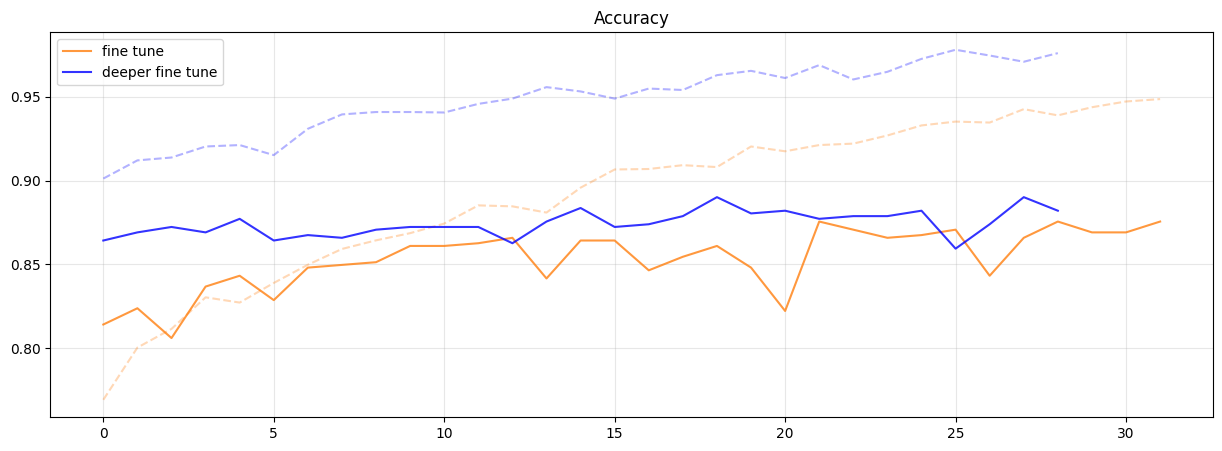

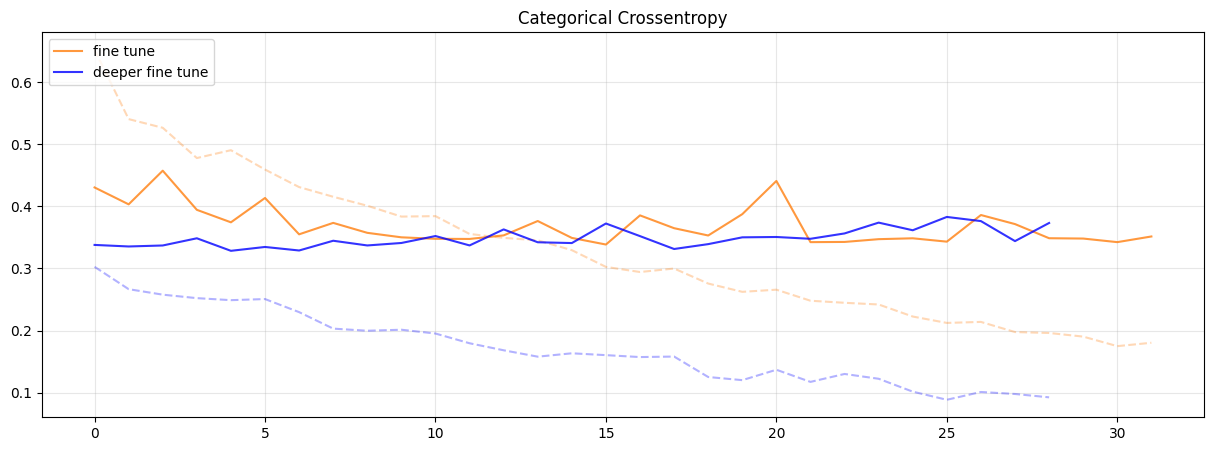

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(ft_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='fine tune', alpha=.8, color='#ff7f0e')
plt.plot(ft_history2['accuracy'], alpha=.3, linestyle='--', color = 'b')
plt.plot(ft_history2['val_accuracy'], label='deeper fine tune', alpha=.8, color = 'b')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(ft_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(ft_history['val_loss'], label='fine tune', alpha=.8, color='#ff7f0e')
plt.plot(ft_history2['loss'], alpha=.3, linestyle='--', color = 'b')
plt.plot(ft_history2['val_loss'], label='deeper fine tune', alpha=.8, color = 'b')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.show()

In [ ]:
ft_model = ft_model.save("upload.keras")